# Set Metric-Establish Baseline-Model Selection-Hyperparameter Tuning

This notebook will perform steps 4 and 5:

4. Set Evaluation Metric & Establish Baseline
5. Model Selection & Tune Hyperparameters of the Model

## Imports

In [1]:
# manipulation libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# normalization and random-search and error metric
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# potential machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb

# to save machine Learning Models
import pickle

## Auxiliary Functions

In [2]:
# functions to use in the notebook
def fit_evaluate_model(model, X_train, y_train, 
                       X_valid, y_valid):
    # function to train a given model
    # return mean squared error of the
    # actuals and predictions
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return mean_squared_error(y_valid, y_predicted)

def convert_features_to_array(features):
    # function to convert feature df
    # to an array
    num_rows = len(features)
    num_cols = len(features.columns)
    
    features_array = (np
                      .array(features)
                      .reshape((num_rows, 
                                num_cols)))

    return features_array

def convert_target_to_array(target):
    # function to convert target df
    # to an array
    target_array = (np
                    .array(target)
                    .reshape((-1, )))
    return target_array

## Load data and convert to array:

In [3]:
X_train = pd.read_csv("../transformed/X_train.csv")
y_train = pd.read_csv("../transformed/y_train.csv")

X_valid = pd.read_csv("../transformed/X_valid.csv")
y_valid = pd.read_csv("../transformed/y_valid.csv")

In [4]:
y_train_array = convert_target_to_array(y_train)
y_valid_array = convert_target_to_array(y_valid)

X_train_array = convert_features_to_array(X_train)
X_valid_array = convert_features_to_array(X_valid)

# Set Evaluation Metric & Establish Baseline

In real-world applications of data science/machine learning, the evaluation metric is set by data scientists in line with the stakeholder’s expectations from the ML model. That is why this is an important step.

## Set Metric

***Mean square error (MSE)*** is the average of sum of squared residuals where a ***residual*** is the a difference between the actual and predicted value of a target variable. In other words, we are going to evaluate our model by looking at the measure of how large our squared errors (residuals) are spread out.

Mean square error is selected as an error metric, because it is interpretable, it is analogous to variance and it also aligns with our selected algorithm's error minimization criteria.  

On the other hand, this error metric is sensitive to extreme values or outliers. Since it takes the square of the differences between the actuals and predictions, in the presence of extreme values and outliers difference grows quadratically.


##  Establish Baseline

Before building moving to the model selection we are going to construct a common-sense baseline with MSE. A ***common-sense baseline*** can be explained as generating a naive guess of the target value by using some expert knowledge or few lines of code.

We are going to select and tune the models that beats this baseline at a significant level. If any of them cannot beat it then machine learning may not be the best approach to solve this problem or whole preprocessing steps needs re-consideration. For our regression problem, a simple common-sense baseline is to predict the variance of the mean of the training set to the validation set. This approach aligns with our evaluation metric MSE as well.

In [5]:
# set baseline as mean of training set's target value
baseline = (np
            .mean(
                y_train_array))
baseline

88.45000745045448

In [6]:
# calculate MSE baseline
mse_baseline = (np
                .mean(
                    np.square(
                        baseline - y_valid_array)))

print("Baseline error is:", round(mse_baseline, 2))

Baseline error is: 9.01


This shows that on average variance between the training points and validation points are 9.01. In other words, sum of squared residuals of average of training points to the validation points is 9.01.

# Select an ML Model Based on the Evaluation Metric

We are going to try one linear algorithm, two distance-based algorithm and three tree-based algorithms:
* Linear regression
* K-nearest neighbors
* Support vector machines
* Random forests regressor
* Extra trees regressor
* Light gradient boostin machines

We are going to train them with the training datasets, and compare their performances by looking at the MSE of the predictions of the validation set.

For now, we will not go into the details of each model, we will observe the run time and the mean squared error reported by each model. We will elaborate on the best model in the last notebook.

## Linear Regresssion

In [7]:
%%time
# linear regression
lr = LinearRegression()
mse_lr=fit_evaluate_model(lr, 
                          X_train_array, 
                          y_train_array, 
                          X_valid_array, 
                          y_valid_array)

print("MSE of linear regression:", mse_lr)

MSE of linear regression: 7.271003914920919
CPU times: user 0 ns, sys: 40.4 ms, total: 40.4 ms
Wall time: 18.6 ms


Linear regression slightly decreased the baseline metric, showing that it is not a candidate to be a good predictor.

## Normalize Datasets for KNN and SVM

Distance-based models use the euclidian distance to train the models, thus varying ranges causes distance-based models to generate inaccurate predictions. In order to try different distance-based models, we are going to scale down the features with normalization.

In [8]:
# create scaler
scaler = StandardScaler()

# apply normalization to training set and transform training set
X_train_array_scaled = (scaler
                        .fit_transform(
                            X_train_array, y_train_array))

# transform validation set
X_valid_array_scaled = scaler.transform(X_valid_array)

## K Nearest Neighbors Regressor

In [9]:
%%time
knn = KNeighborsRegressor()
mse_knn = fit_evaluate_model(knn,
                             X_train_array_scaled, 
                             y_train_array, 
                             X_valid_array_scaled, 
                             y_valid_array)

print("MSE of knn regressor:", mse_knn)

MSE of knn regressor: 6.374447921323201
CPU times: user 409 ms, sys: 273 ms, total: 682 ms
Wall time: 147 ms


K-nearest regressor performed better than the linear regression however, MSE is still high, showing that this algorithm is not a good predictor.

## Support Vector Machines Regressor

In [10]:
%%time
svm = SVR()
mse_svm = fit_evaluate_model(svm,
                             X_train_array_scaled, 
                             y_train_array, 
                             X_valid_array_scaled, 
                             y_valid_array)

print('MSE of Support Vector Machines:', mse_svm)

MSE of Support Vector Machines: 5.860241966386057
CPU times: user 1.67 s, sys: 52.5 ms, total: 1.73 s
Wall time: 1.73 s


Support vector machines performed better than the k-nearest neighbors at a higher run-time. All in all MSE decreased 35% showing that this algorithm might be a candidate for a building a good predictor.

## Random Forests Regressor

In [11]:
%%time
rf = RandomForestRegressor(random_state=42)
mse_rf = fit_evaluate_model(rf,
                            X_train_array,
                            y_train_array,
                            X_valid_array,
                            y_valid_array)

print("MSE of Random Forests", mse_rf)

MSE of Random Forests 5.405698983941461
CPU times: user 2.08 s, sys: 4.85 ms, total: 2.09 s
Wall time: 2.11 s


## Extra Trees Regressor

In [12]:
%%time
xrf = ExtraTreesRegressor(random_state=42)
mse_xrf = fit_evaluate_model(xrf,
                             X_train_array,
                             y_train_array,
                             X_valid_array,
                             y_valid_array)

print("MSE of Random Forests", mse_xrf)

MSE of Random Forests 5.994965056126757
CPU times: user 1.42 s, sys: 41.6 ms, total: 1.46 s
Wall time: 1.46 s


Extra-trees regressor performed worse than the random forests and support vector machines, thus it showed that it is not a good candidate for a good predictor.

## Light Gradient Boosting Regressor

In [13]:
%%time
lgbm = lgb.LGBMRegressor(random_state=42)
mse_lgbm = fit_evaluate_model(lgbm,
                              X_train_array,
                              y_train_array,
                              X_valid_array,
                              y_valid_array)

print("MSE of light gradient boosting algorithm", mse_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 6711, number of used features: 14
[LightGBM] [Info] Start training from score 88.450007
MSE of light gradient boosting algorithm 4.968934649974784
CPU times: user 470 ms, sys: 0 ns, total: 470 ms
Wall time: 103 ms


Light gradient boosting machines has the best performance of all tried models. It also lowered the baseline MSE 45% and showed that it is a potential candidate for a good predictor at a lower run time.

## Findings from model selection

/tmp/ipykernel_15099/3671764688.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="MSE",


Text(0.5, 1.0, 'MSE of Different Algorithms')

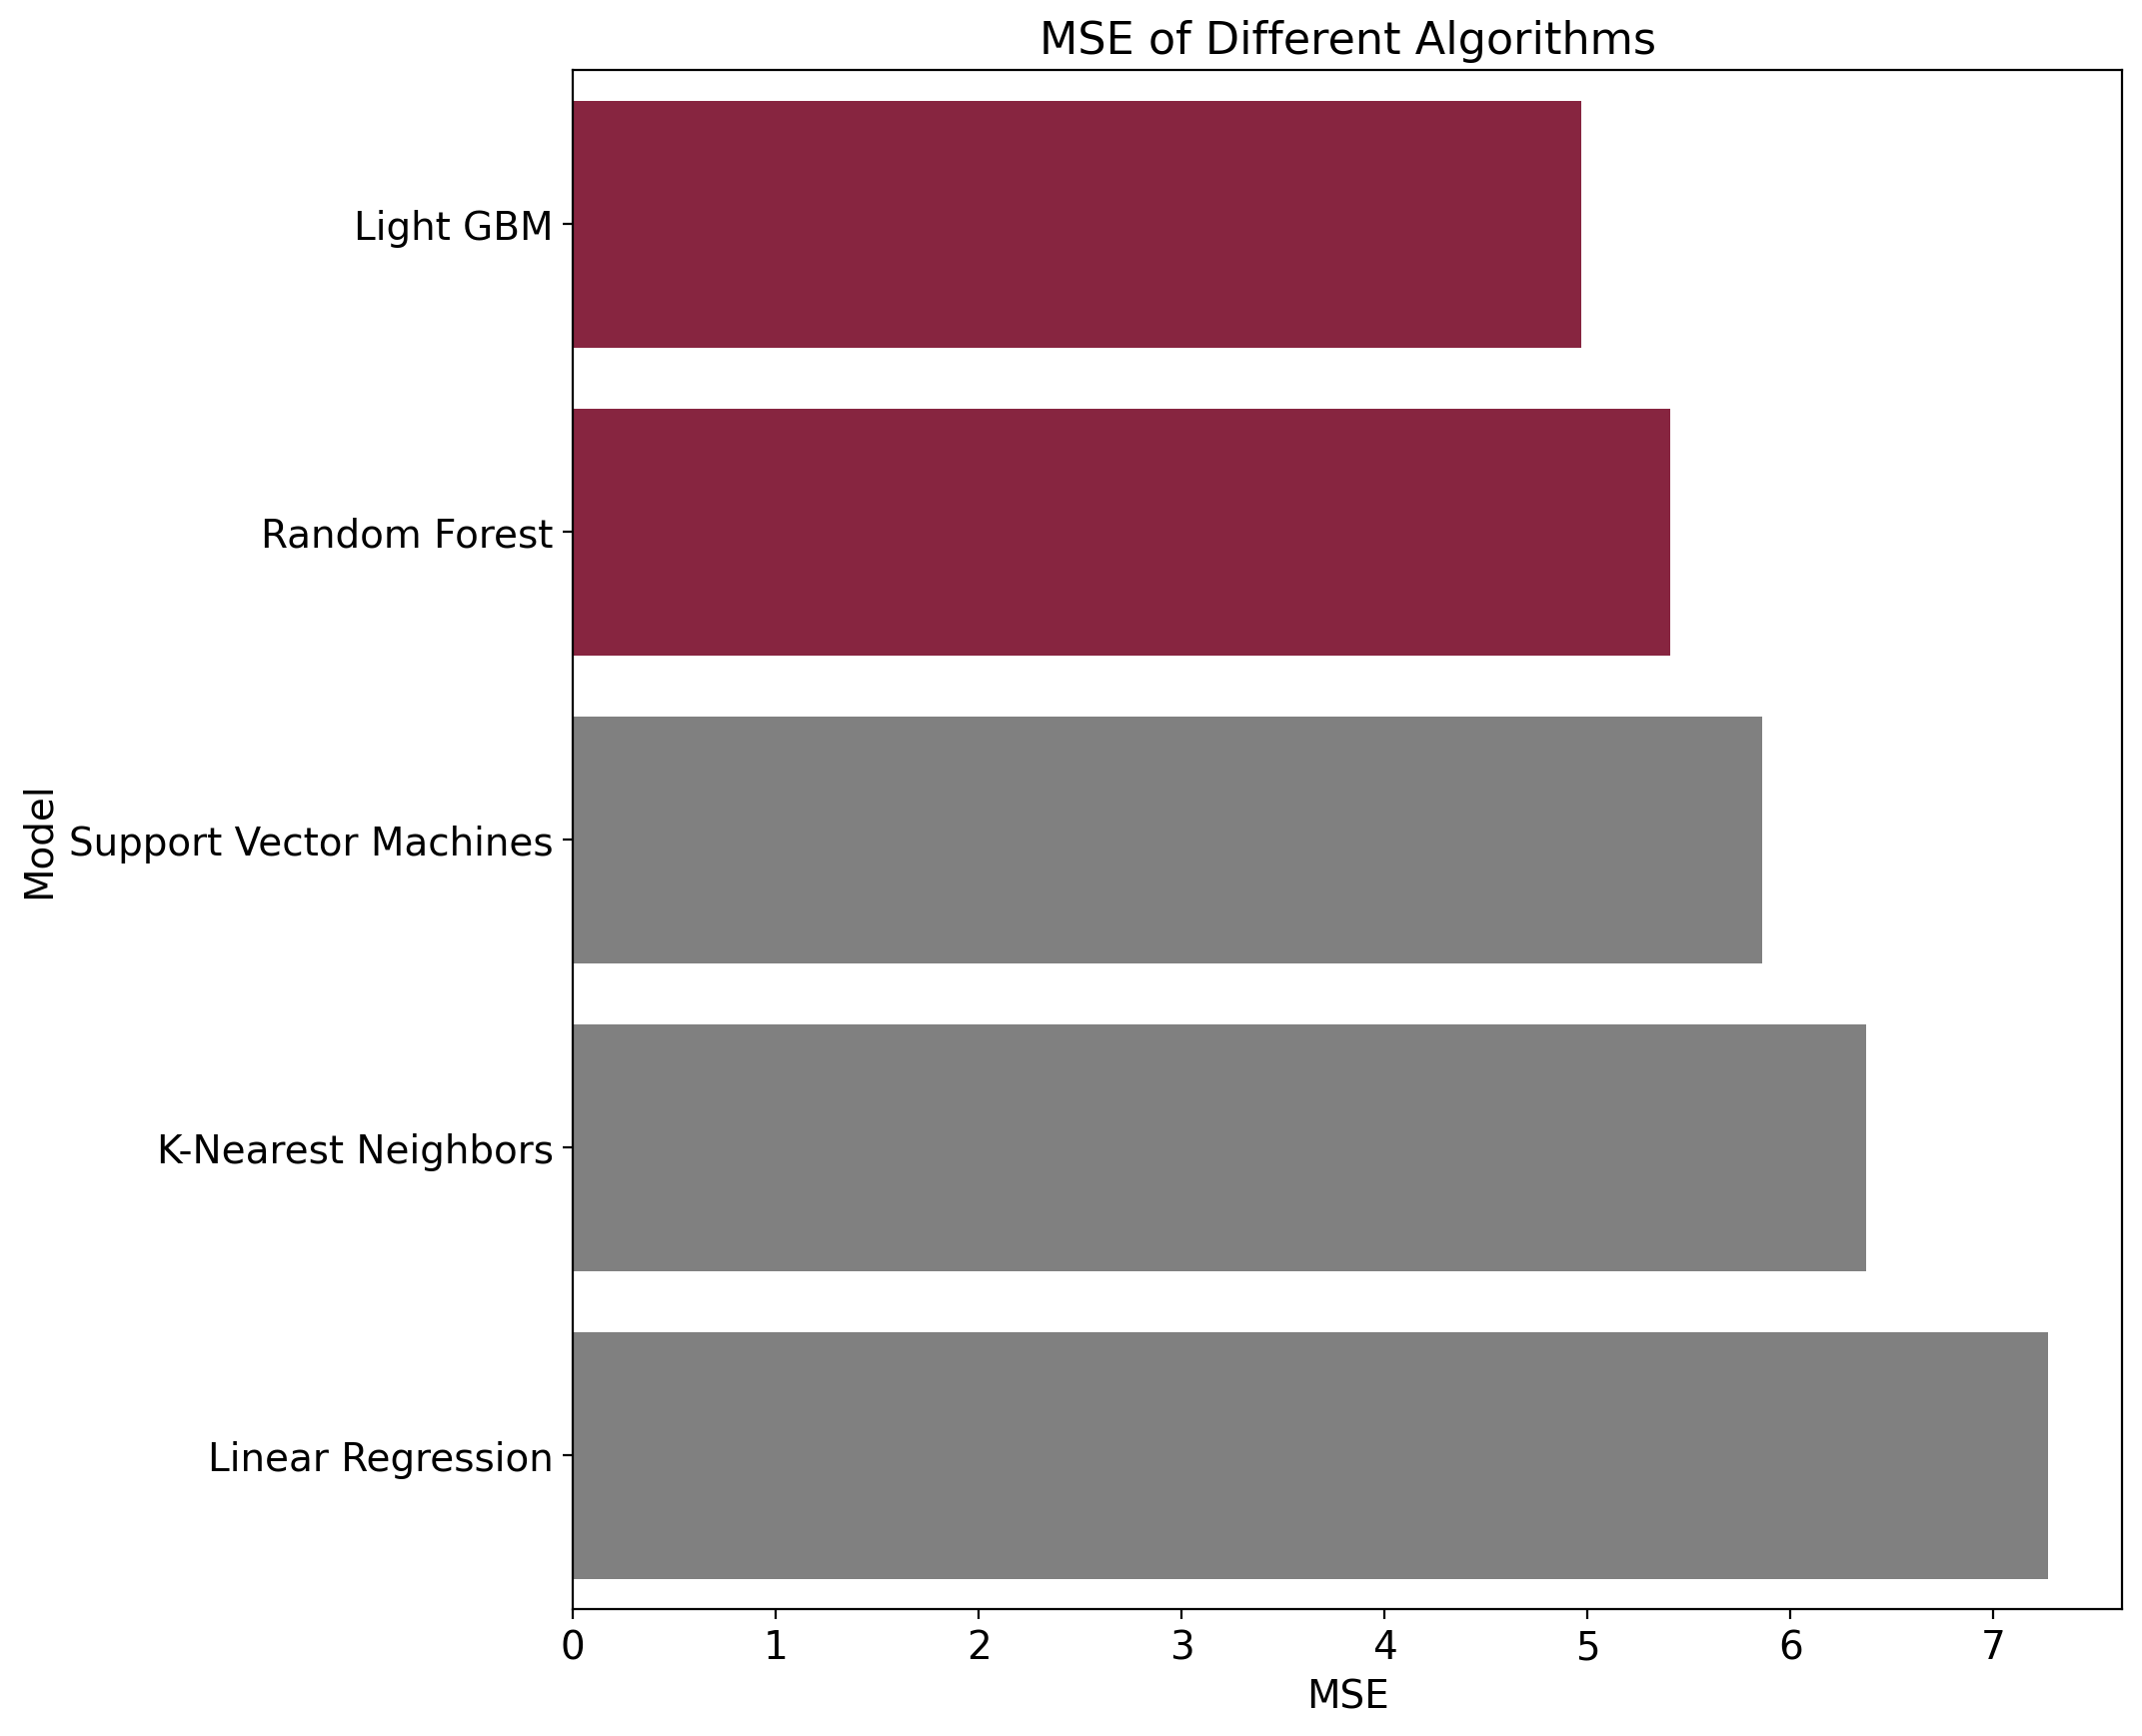

In [14]:
# create dataframe of mse and model and sort values
performance_comparison = pd.DataFrame({"Model": 
                                       ["Linear Regression", "K-Nearest Neighbors", 
                                        "Support Vector Machines", "Random Forest", 
                                        "Light GBM"],
                                       "MSE": 
                                       [mse_lr, mse_knn, mse_svm, 
                                        mse_rf, mse_lgbm]})

performance_comparison = performance_comparison.sort_values(by="MSE", ascending=True)


# set the font and size
plt.rcParams['font.size'] = 14
plt.figure(figsize=(10,10))

# set color
labels = np.array(performance_comparison.Model)
values = np.array(performance_comparison.MSE) 
# colors = ["#808080" if y > 5.0 else "#971539" for y in values]
colors = ["#971539", "#971539", "#808080", "#808080", "#808080"]
            
ax = sns.barplot(x="MSE", 
                 y="Model", 
                 data=performance_comparison,
                 palette = colors)

# set title arrange labels
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("MSE of Different Algorithms", size=16)

Random forests and light gradient boosting algorithms showed that they are potential good predictors for a wine rating predictor. Both decreased baseline MSE more than 40%. In the following part, we are going to look for further improvements in both models by using random search with cross validation and hyperparameter tuning.

# Tune Hyperparameters of the Models

A hyperparameter is the set of defined parameter(s) by the data scientist or ML engineer whose values are not affected by the training process of the model. On the other hand, a parameter of a model is searched and optimized by the model during the training process and affected by the dataset.

We are going to search for the best set of parameters with random search and k-fold cross validation.

***Random search*** is the process of randomly combination of the defined parameters and compares the defined score (mean squared error, for this problem) with iterations. So, the most optimal set might be different than the random search results. However, this search algorithm is fast and run-time efficient.

***K-fold Cross Validation*** is the method used to assess the performance of the hyperparameters on the whole dataset. Rather than splitting the dataset set into 2 static subsets of training and validation set, dataset is divided equally for the given K. Then the model is trained with K-1 subsets and tested on Kth subset iteratively. This process makes each process more robust.

In [15]:
# add dataframes back for to perform random search and cross-validation
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

X_array = convert_features_to_array(X)
y_array = convert_target_to_array(y)